In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## handy function

In [2]:
import time
import torch
import math
import os
import numpy as np



def print_current_time(output=''):
    import datetime
    import pytz
    current_time = datetime.datetime.now(pytz.timezone('Israel'))
    if output == '':
        print("The current time is: ")
    else:
        print(output)
    print(current_time)


def move_x_and_y_cpu( x, y):
        x = x.cpu()
        y = y.cpu()
        return (x,y)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (%s)' % (asMinutes(s), asMinutes(rs))


def calculate_accuracy(outputs, labels):
    pred = torch.argmax(outputs, dim=1)
    total = labels.size(0)
    correct = (pred == labels).sum().item()
    return correct, total


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def top_k_accuracy(outputs, labels, k):
    top_p, top_class = outputs.topk(k, dim=1)
    top_class = top_class.t()
    correct = top_class.eq(labels.view(1, -1).expand_as(top_class))
    total = labels.size(0)
    correct_k = correct.float().sum().item()
    return correct_k, total    







## tokenizing

In [3]:
!pip install transformers

     |████████████████████████████████| 2.2MB 21.8MB/s 
     |████████████████████████████████| 870kB 50.9MB/s 
     |████████████████████████████████| 3.3MB 46.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=99c8e474ed4f91d58a3d8b6a3c8c0d7ce631b3f95ef84595a39d3868c036175c
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [4]:
from transformers import BertTokenizer
import torch

class Tokenizing:
    def __init__(self, df_songs):
        self.df_songs = df_songs
        self.max_embed_batch_len = 512
        self.songs_dict = dict()
        self.tokenizer = None
        self.create_tokenizer_instance()

    def create_tokenizer_instance(self):
        # Load the BERT tokenizer.
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    def tokenizing_batch(self, batch):
        """
        For every single song

        """

        # `encode_plus` will:
        #   (1) Tokenize the batch.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = self.tokenizer.encode_plus(
            batch,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_embed_batch_len,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt'  # Return pytorch tensors.
        )
        return encoded_dict

    def tokenize_each_song(self, tokenizing_path=None):
        """
        For all songs

        """
        print_current_time("starting tokenizing process")

        # if saved tokenizing
        if tokenizing_path is not None:
            self.songs_dict = torch.load(tokenizing_path)
            self.tokenizing_path = tokenizing_path
        else:
            for i in range(len(self.df_songs)):
                key = (self.df_songs.loc[i, "Artist"], self.df_songs.loc[i, "Song_name"])

                batch_lyrics = self.df_songs.loc[i, "Lyrics"]

                token_batch_lyrics = self.tokenizing_batch(batch_lyrics)
                token_batch_lyrics_data = token_batch_lyrics.data

                token_batch_lyrics_data['Lyrics'] = batch_lyrics

                self.songs_dict[key] = token_batch_lyrics_data


            


        print_current_time("finished tokenizing process")


## bertclassifer

In [5]:
from transformers import BertForSequenceClassification, BertConfig

class BERTClassifer():


  def __init__(self, args, device):


    # config = BertConfig.from_pretrained('bert-base-uncased')
    # config.num_labels = args.class_number
    # self.model = BertForSequenceClassification(config)

    # Load BertForSequenceClassification, the pretrained BERT model with a single
    # linear classification layer on top.
    self.model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
        num_labels= args.class_number,  # The number of output labels
        # You can increase this for multi-class tasks.
        output_attentions=False,  # Whether the model returns attentions weights.
        output_hidden_states=False,  # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    if device.type == 'cuda':
     self.model.cuda()


  # def embed_and_predict(self,token_songs_batch, device):
  #
  #    b_input_ids =token_songs_batch[0].to(device)
  #    b_input_mask =token_songs_batch[1].to(device)
  #    b_labels =token_songs_batch[2].to(device)
  #    b_labels =  b_labels.squeeze_()
  #
  #    loss, logits = self.model(b_input_ids,
  #                         token_type_ids=None,
  #                         attention_mask=b_input_mask,
  #                         labels=b_labels)
  #    return(logits)







## upload data to dataloader

In [6]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np




class upload_data_to_dataloader:

    def __init__(self, orig_songs_df, data, args,   tokenized_data = False ):

        self.labels = orig_songs_df['label'].values
        self.data = data
        self.args = args

        self.create_dataloader(tokenized_data)



    def create_dataloader(self,  tokenized_data):

       if  not tokenized_data:
            self.upload_emd_data()
       else:
            self.upload_tokenized_data()


    def upload_emd_data(self):

        train_features, test_features, train_labels, test_labels = train_test_split(self.data, self.labels,
                                                                                    test_size=self.args.test_ratio,
                                                                                    random_state=42)

        if self.args.validation_ratio > 0:
            train_features, val_features, train_labels, val_labels = train_test_split(train_features,
                                                                                      train_labels,
                                                                                      test_size=self.args.validation_ratio,
                                                                                      random_state=42
                                                                                      )
            val_dataset = TensorDataset(val_features, torch.from_numpy(val_labels))

            self.val_dataloader = DataLoader(val_dataset, batch_size=self.args.val_batch_size)

        tr_dataset = TensorDataset(train_features, torch.from_numpy(train_labels))

        self.tr_dataloader = DataLoader(tr_dataset, batch_size=self.args.tr_batch_size)

        test_dataset = TensorDataset(test_features, torch.from_numpy(test_labels))

        self.test_dataloader = DataLoader(test_dataset, batch_size=self.args.test_batch_size)



    def upload_tokenized_data(self):

        input_ids_data,  attention_mask_data  =   self.get_input_ids_att_maks_lists()

        train_input_id_data,  test_input_id_data,\
        train_attention_mask_data, test_attention_mask_data, \
        train_labels, test_labels = train_test_split(input_ids_data,  attention_mask_data, self.labels,test_size=self.args.test_ratio,   random_state=42)

        if self.args.validation_ratio > 0:
            train_input_id_data, val_input_id_data, \
            train_attention_mask_data, val_attention_mask_data, \
            train_labels, val_labels = train_test_split(train_input_id_data, train_attention_mask_data,  train_labels,
                                                         test_size=self.args.validation_ratio , random_state=42)

            val_dataset = TensorDataset(val_input_id_data, val_attention_mask_data ,torch.from_numpy(val_labels))

            self.val_dataloader = DataLoader(val_dataset, batch_size=self.args.val_batch_size)

        tr_dataset = TensorDataset(train_input_id_data, train_attention_mask_data ,torch.from_numpy(train_labels))

        self.tr_dataloader = DataLoader(tr_dataset, batch_size=self.args.tr_batch_size)

        test_dataset = TensorDataset(test_input_id_data, test_attention_mask_data ,torch.from_numpy(test_labels))

        self.test_dataloader =  DataLoader(test_dataset, batch_size=self.args.tr_batch_size)





    def get_input_ids_att_maks_lists(self):

        input_ids_data = torch.tensor([])
        attention_masks_data = torch.tensor([])

        for key, token_song in self.data.items():
                input_ids = token_song.get('input_ids')
                input_ids_data= torch.cat((input_ids_data,input_ids), dim = 0)

                attention_mask = token_song.get('attention_mask')
                attention_masks_data = torch.cat(( attention_masks_data, attention_mask), dim=0)


        return  input_ids_data, attention_masks_data








## train net

In [7]:
# import pandas as pd
from tqdm import tqdm
import torch
import time
import copy

# import pandas as pd
from tqdm import tqdm
import torch
import time
import copy


class TrainNet:
    def __init__(self, train_dataloader, net, optimizer, device, args, val_dataloader=None, save= False,  tr_bert_classifer = False,use_validation= True, k=5 ):

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.net = net
        #self.best_net = None
        self.device = device
        self.save = save
        self.use_validation = use_validation
        self.num_epochs = args.num_epochs
        self.criterion = args.criterion
        self.early_stop_n = args.early_stop_n
        self.early_stop_acc_value = args.early_stop_acc_value
        self.tr_bert_classifer = tr_bert_classifer
        self.k = k

        self.epoch_before_early_stop = 0
        self.val_best_acc_epoch = 0
        self.val_acc_value_before_eraly_stop = 0.0
        self.val_loss_value_before_eraly_stop = 0.0
        self.tr_bert_classifer = tr_bert_classifer
        self.val_best_acc_value = 0.0
        self.val_best_loss_value = 100000.0




        self.train_loss = [None] *  self.num_epochs
        self.val_loss = [None] *  self.num_epochs

        self.train_acc = [None] *  self.num_epochs
        self.train_acc_k = [None] * self.num_epochs

        self.val_acc = [None] *  self.num_epochs
        self.val_acc_k = [None] * self.num_epochs




        self.train_net(tr_bert_classifer)

    def train_net(self, tr_bert_classifer= False):

        start = time.time()
        print_current_time("starting to train classifier net")
        epoch_total_train_loss = 0.0  # Reset every epoch

        for epoch in range( self.num_epochs):

            for tr_batch in tqdm(self.train_dataloader):

                self.net.train()
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward
                loss, y_pred = self.forwad(tr_batch)

                # backward + optimize
                y_train = self.get_labels(tr_batch)
                loss = self.get_loss(loss, y_pred, y_train)
                loss.backward()
                self.optimizer.step()

                epoch_total_train_loss += loss.item()

            # train metrics
            self.train_loss[epoch] = epoch_total_train_loss / len(self.train_dataloader)
            epoch_total_train_loss = 0.0

            self.train_acc[epoch], self.train_acc_k[epoch], _ = self.evaluate(self.train_dataloader)

            if self.use_validation:
                # val metrics
                self.val_acc[epoch], self.val_acc_k[epoch], self.val_loss[epoch] = self.evaluate(self.val_dataloader, True)
                self.update_best_val_loss_acc(self.val_acc[epoch], self.val_loss[epoch], epoch )
                self.print_metrics(epoch, start, False )


                self.epoch_before_early_stop = epoch
                self.val_acc_value_before_eraly_stop =   self.val_acc[epoch]
                self.val_loss_value_before_eraly_stop =  self.val_loss[epoch]
                #early stop check
                if self.early_stopping_check(epoch):
                        break



            self.print_metrics(epoch, start)
            # print(f'Epoch #{epoch}:\n'
            #       f'Last batch Loss: {loss.item():.4f}\n'
            #       f'Train accuracy: {epoch_total_train_acc:.3f}\n'
            #       f'Test accuracy: {test_accuracy:.3f}\n'
            #       f'Time elapsed (remaining): {timeSince(start, (epoch+1) /  self.num_epochs)}')

            if self.save:
                save_model(self.net, epoch)



    def print_metrics(self, epoch, start, train=True):
        if epoch % 1 == 0 or epoch == self.num_epochs-1:
            print()
            print("******************************")

            if train:
                print(f'Epoch #{epoch + 1}:\n'
                      f'Train Loss: {self.train_loss[epoch]:.4f}\n'
                      f'Train accuracy: {self.train_acc[epoch]:.4f}\n'
                      f'Train k-accuracy: {self.train_acc_k[epoch]:.3f}\n'
                      f'Time elapsed (remaining): {timeSince(start, (epoch + 1) / self.num_epochs)}')

            else:

                print(f'Epoch #{epoch + 1}:\n'
                      f'Validation Loss: {self.val_loss[epoch]:.4f}\n'
                      f'Validation accuracy: {self.val_acc[epoch]:.4f}\n' 
                      f'Validation k-accuracy: {self.val_acc_k[epoch]:.3f}\n')

    def early_stopping_check(self, curr_epoch):
        if curr_epoch <  self.early_stop_n :
            return False



        for i in range(0,  self.early_stop_n):
            if self.val_acc[curr_epoch - i] - self.val_acc[curr_epoch - i - 1] >= self.early_stop_acc_value:
                return False


        print("made early stopping after epoch: ", curr_epoch)
        return True

    def evaluate(self, dataloader, val = False):

        total = 0.0
        correct = 0.0
        epoch_val_loss = 0.0
        correct_k = 0.0
        self.net.eval()

        with torch.no_grad():

            for val_batch in tqdm(dataloader):
                loss,outputs = self.forwad(val_batch)

                labels = self.get_labels(val_batch)
                current_correct, current_total = calculate_accuracy(outputs, labels)
                current_k_correct, _ = top_k_accuracy(outputs, labels, k=self.k)

                correct_k += current_k_correct
                correct += current_correct
                total += current_total

                if val:
                    val_loss = self.criterion(outputs, labels.long())
                    epoch_val_loss += val_loss.item()

        accuracy = correct / total
        k_accuracy = correct_k / total
        epoch_val_avg_loss = epoch_val_loss/len(self.train_dataloader)

        return accuracy, k_accuracy, epoch_val_avg_loss

    def forwad(self, batch):

        loss = -1

        if self.tr_bert_classifer:

            b_input_ids  =  batch[0].to(self.device).long()
            b_input_mask =  batch[1].to(self.device)
            b_labels     =  batch[2].to(self.device).long()
            #b_labels = b_labels.squeeze_()

            loss, y_pred = self.net(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels,
                                 return_dict=False
                                    )
        else:
            x_train = batch[0]
            x_train = x_train.to(self.device)

            y_pred = self.net(x_train)


        return loss, y_pred



    def get_labels(self, batch):

        if self.tr_bert_classifer:
            labels = batch[2].to(self.device)

        else:
            labels = batch[1].to(self.device)

        labels = labels.squeeze_()

        return labels

    def get_loss(self, loss, y_pred, y_train):

        if self.tr_bert_classifer:
            return loss

        else:
            loss = self.criterion(y_pred, y_train.long())
            return loss

    def update_best_val_loss_acc(self,  last_epoch_acc_value,  last_epoch_loss_value, epoch):

        if last_epoch_acc_value > self.val_best_acc_value:
            self.val_best_acc_value= last_epoch_acc_value
            self.val_best_acc_epoch = epoch
            #self.best_net = copy.deepcopy(self.net)

        if last_epoch_loss_value < self.val_best_loss_value:
            self.val_best_loss_value =  last_epoch_loss_value


  


























##Preproccess Data

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


class PreprocessData:

    def __init__(self, song_csv_path, max_word):
        self.df_songs = pd.read_csv(song_csv_path)
        self.filtered_df_songs = pd.DataFrame()
        self.max_words = max_word

        self.add_labels()
        self.delete_songs_more_n_words(self.max_words)

    def add_labels(self):
        labelencoder = LabelEncoder()
        self.df_songs["label"]=labelencoder.fit_transform(self.df_songs["Artist"])

    def delete_songs_more_n_words(self, max_n_words):
        self.df_songs['words_num'] =   self.df_songs.Lyrics.apply(lambda x: len(str(x).replace("\n"," " ).split(' ')))
        # from collections import Counter
        # self.df_songs['words_num'] =self.df_songs['lyrics'].apply(lambda x: Counter(" ".join(x).split(" ")).items())
        self.filtered_df_songs =  self.df_songs[self.df_songs['words_num'] <= max_n_words].reset_index()


## args

In [9]:
import torch.nn.functional


class args:

  def __init__(self):

    #NN architecture args
    self.input_size = 768
    self.class_number= 19
    self.p1= 0.5
    self.p2 = 0.25
    self.fc1_output_size = 256
    self.fc2_output_size = 64


    # Train-test split args
    self.validation_ratio = 0.2
    self.test_ratio = 0.2

    # NN training args
    self.tr_batch_size =  8
    self.val_batch_size = 8
    self.num_epochs = 10

    # NN back propagation arg0s
    self.lr = 2e-5
    self.weight_decay= 0.001
    self.criterion = torch.nn.CrossEntropyLoss()

    # NN early stopping args
    self.early_stop_n = 3
    self.early_stop_acc_value = 0




## Plots

In [10]:
from matplotlib import pyplot as plt
from datetime import datetime
import os
import numpy as np

def plot_accuracies(train_accs, test_accs, model_name):
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.figure(figsize=(20, 8))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    # plt.tight_layout()
    plt.plot(train_accs, label='train')
    plt.plot(test_accs, label='validation')
    plt.title(f'{model_name} accuracy')
    plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
    plt.yticks(np.around(np.linspace(0.0, 1.0, num=11), decimals=1))
    plt.legend()
    # plt.grid(True)
    #plt.savefig(os.path.join(FIGURES_DIR, f'{model_name}_accuracy_{current_time}.png'))
    plt.show()


def plot_loss(train_loss, val_loss, model_name):
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.figure(figsize=(20, 8))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.tight_layout()
    plt.plot(train_loss,  label='training')
    plt.plot(val_loss,   label='validation')
    plt.legend()

    plt.title(f'{model_name} loss')
    plt.xticks(range(len(train_loss)), range(1, len(train_loss) + 1))
    # plt.yticks(np.around(np.linspace(0.0, 1.0, num=11), decimals=1))
    # plt.grid(True)
    #plt.savefig(os.path.join(FIGURES_DIR, f'{model_name}_loss_{current_time}.png'))
    plt.show()


## MAIN

cuda
Loading BERT tokenizer...



starting tokenizing process
2021-04-13 10:21:50.082825+03:00
finished tokenizing process
2021-04-13 10:21:53.639221+03:00


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

starting to train classifier net
2021-04-13 10:22:40.972145+03:00


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #1:
Validation Loss: 0.5697
Validation accuracy: 0.3104
Validation k-accuracy: 0.718


******************************
Epoch #1:
Train Loss: 2.6824
Train accuracy: 0.3595
Train k-accuracy: 0.764
Time elapsed (remaining): 12m 51s (115m 40s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #2:
Validation Loss: 0.4717
Validation accuracy: 0.4363
Validation k-accuracy: 0.800


******************************
Epoch #2:
Train Loss: 2.0033
Train accuracy: 0.6265
Train k-accuracy: 0.914
Time elapsed (remaining): 25m 40s (102m 43s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #3:
Validation Loss: 0.4717
Validation accuracy: 0.4309
Validation k-accuracy: 0.801


******************************
Epoch #3:
Train Loss: 1.3700
Train accuracy: 0.7803
Train k-accuracy: 0.968
Time elapsed (remaining): 38m 30s (89m 51s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #4:
Validation Loss: 0.5110
Validation accuracy: 0.4355
Validation k-accuracy: 0.785


******************************
Epoch #4:
Train Loss: 0.8325
Train accuracy: 0.8642
Train k-accuracy: 0.986
Time elapsed (remaining): 51m 20s (77m 0s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #5:
Validation Loss: 0.5410
Validation accuracy: 0.4587
Validation k-accuracy: 0.788


******************************
Epoch #5:
Train Loss: 0.5074
Train accuracy: 0.9262
Train k-accuracy: 0.995
Time elapsed (remaining): 64m 10s (64m 10s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #6:
Validation Loss: 0.5992
Validation accuracy: 0.4247
Validation k-accuracy: 0.770


******************************
Epoch #6:
Train Loss: 0.3504
Train accuracy: 0.9250
Train k-accuracy: 0.997
Time elapsed (remaining): 77m 0s (51m 20s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #7:
Validation Loss: 0.6380
Validation accuracy: 0.4046
Validation k-accuracy: 0.760


******************************
Epoch #7:
Train Loss: 0.2210
Train accuracy: 0.9704
Train k-accuracy: 0.998
Time elapsed (remaining): 89m 50s (38m 30s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #8:
Validation Loss: 0.6521
Validation accuracy: 0.4255
Validation k-accuracy: 0.761


******************************
Epoch #8:
Train Loss: 0.1665
Train accuracy: 0.9753
Train k-accuracy: 0.999
Time elapsed (remaining): 102m 41s (25m 40s)


  0%|          | 0/647 [00:00<?, ?it/s]


******************************
Epoch #9:
Validation Loss: 0.6852
Validation accuracy: 0.4301
Validation k-accuracy: 0.764


******************************
Epoch #9:
Train Loss: 0.1392
Train accuracy: 0.9778
Train k-accuracy: 0.999
Time elapsed (remaining): 115m 33s (12m 50s)


100%|██████████| 162/162 [00:47<00:00,  3.39it/s]


******************************
Epoch #10:
Validation Loss: 0.7341
Validation accuracy: 0.3977
Validation k-accuracy: 0.738


******************************
Epoch #10:
Train Loss: 0.1036
Train accuracy: 0.9500
Train k-accuracy: 0.998
Time elapsed (remaining): 128m 25s (0m 0s)
best validation accuracy was:  0.4587 after epoch number:  4


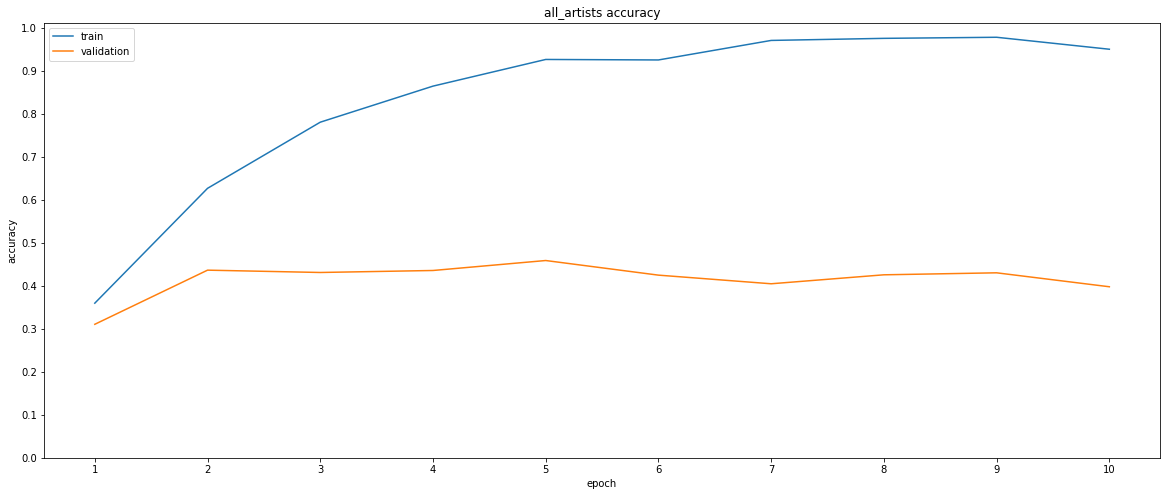

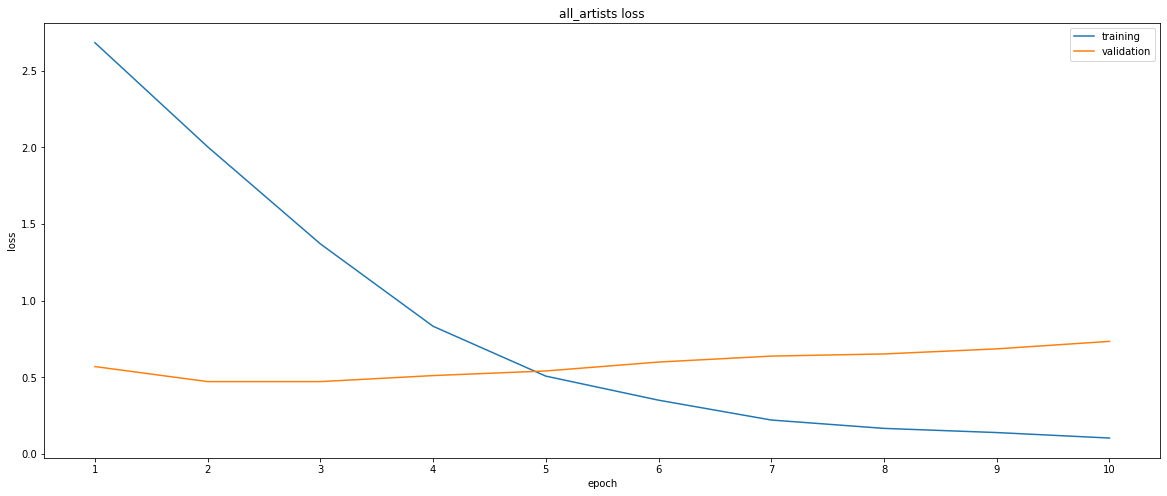

In [11]:
import torch
import os
from torch import optim

tr_bert_classifer =  True

# set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#args
args = args()


# pre-process data
data_file ="/content/drive/MyDrive/NLP_FINAL_PROJECT/DATA/all_songs_nineteen_artists.csv"
songs_df = PreprocessData(data_file, 512)

# tokenize songs
tokenizing_path = "/content/drive/MyDrive/NLP_FINAL_PROJECT/DATA/all_songs_token.pt"
song_token = Tokenizing(df_songs= songs_df.filtered_df_songs )
song_token.tokenize_each_song(tokenizing_path)

if tokenizing_path is None:
    torch.save(song_token.songs_dict, PARAMETERS_DIR + "\\all_songs_token.pt")

if not tr_bert_classifer:
    # song embeddings
    embedding_path = os.path.join(PARAMETERS_DIR, "embedding_all_artist.pt")
    embedding_songs = Embedding(tokenizing_data=song_token.songs_dict, device=device, embedding_path= embedding_path)
    embedding_songs.data_embedding()

    if embedding_songs.embedding_path is None:
        torch.save(embedding_songs.songs_features,  PARAMETERS_DIR + "\\embedding_all_artist.pt" )

    # create dataloader from embeddings
    embedding_dataloaders = upload_data_to_dataloader(song_token.df_songs, embedding_songs.songs_features, args= args)

else:
    embedding_dataloaders = upload_data_to_dataloader(song_token.df_songs, song_token.songs_dict, args=args, tokenized_data= True)

# train classification net
if tr_bert_classifer:

    bert_classifer = BERTClassifer(args, device)
    untrained_net = bert_classifer.model


else:
    untrained_net = ClassificationNet(args, input_size=args.input_size).to(device)

untrained_net_final = copy.deepcopy(untrained_net)


LR = args.lr
WEIGHT_DECAY = args.weight_decay

if WEIGHT_DECAY > 0:
    adam_optimizer = optim.Adam(untrained_net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    adam_optimizer = optim.Adam(untrained_net.parameters(), lr=LR)


trained_net = TrainNet(train_dataloader=embedding_dataloaders.tr_dataloader, optimizer=adam_optimizer,
                                      device=device, net=    untrained_net,
                                      val_dataloader=embedding_dataloaders.val_dataloader,
                                      args= args, tr_bert_classifer = tr_bert_classifer)

model_result = {'loss': trained_net.train_loss, 'train_acc': trained_net.train_acc, 'test_acc': trained_net.val_acc}


print("best validation accuracy was: ", round(trained_net.val_best_acc_value, 4), "after epoch number: ", trained_net.val_best_acc_epoch)


#plot figures
plot_accuracies(trained_net.train_acc, trained_net.val_acc, 'all_artists')
plot_loss(trained_net.train_loss, trained_net.val_loss, 'all_artists')








In [12]:




print("training final net")


args.validation_ratio = 0
args.early_stop_n = 1000000
args.num_epochs = trained_net.val_best_acc_epoch

del trained_net



if not tr_bert_classifer:
    embedding_dataloaders_without_val = upload_data_to_dataloader(song_token.df_songs, embedding_songs.songs_features, args= args)


else:
    embedding_dataloaders_without_val = upload_data_to_dataloader(song_token.df_songs, song_token.songs_dict, args=args, tokenized_data= True)


if WEIGHT_DECAY > 0:
    adam_optimizer = optim.Adam(untrained_net_final.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    adam_optimizer = optim.Adam(untrained_net_final.parameters(), lr=LR)



final_net = TrainNet(train_dataloader= embedding_dataloaders_without_val.tr_dataloader, optimizer=adam_optimizer,
                                      device=device, net= untrained_net_final,
                                      val_dataloader=embedding_dataloaders_without_val.test_dataloader,
                                      args= args, tr_bert_classifer = tr_bert_classifer)





training final net


  0%|          | 0/809 [00:00<?, ?it/s]

starting to train classifier net
2021-04-13 12:31:31.095257+03:00


  0%|          | 0/809 [00:00<?, ?it/s]


******************************
Epoch #1:
Validation Loss: 0.5618
Validation accuracy: 0.3226
Validation k-accuracy: 0.730


******************************
Epoch #1:
Train Loss: 2.6156
Train accuracy: 0.4087
Train k-accuracy: 0.788
Time elapsed (remaining): 16m 8s (48m 26s)


  0%|          | 0/809 [00:00<?, ?it/s]


******************************
Epoch #2:
Validation Loss: 0.4836
Validation accuracy: 0.4091
Validation k-accuracy: 0.802


******************************
Epoch #2:
Train Loss: 1.9052
Train accuracy: 0.6458
Train k-accuracy: 0.922
Time elapsed (remaining): 32m 16s (32m 16s)


  0%|          | 0/809 [00:00<?, ?it/s]


******************************
Epoch #3:
Validation Loss: 0.4871
Validation accuracy: 0.4289
Validation k-accuracy: 0.807


******************************
Epoch #3:
Train Loss: 1.2503
Train accuracy: 0.8068
Train k-accuracy: 0.970
Time elapsed (remaining): 48m 24s (16m 8s)


100%|██████████| 203/203 [00:59<00:00,  3.39it/s]


******************************
Epoch #4:
Validation Loss: 0.5278
Validation accuracy: 0.4468
Validation k-accuracy: 0.791


******************************
Epoch #4:
Train Loss: 0.7571
Train accuracy: 0.8917
Train k-accuracy: 0.988
Time elapsed (remaining): 64m 30s (0m 0s)
